### Load libraries and setup environment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re

# remove scientific notation display for floats
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### If you'd like to replicate our API calls, uncomment the code below and place a TMDb API key in your config folder.
Information on obtaining an API key can be found here: https://developers.themoviedb.org/3/getting-started/introduction

In [2]:
# import config
# api_key = config.api_key

# Data Sources. Extracting and Cleaning

## The Movie DataBase

### TMDB info

In [3]:
tmdb_movie_db = pd.read_csv('Data/tmdb.movies.csv.gz', compression='gzip')
tmdb_movie_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
Unnamed: 0           26517 non-null int64
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


#### separate animated movies and non-animated movies (16 is the genre id for animation)

In [4]:
tmdb_animated_info_df = tmdb_movie_db[tmdb_movie_db['genre_ids'].str.contains('16')]

In [5]:
tmdb_non_animated_info_df = tmdb_movie_db[~tmdb_movie_db['genre_ids'].str.contains('16')]

### TMDB budgets

In [6]:
tmbd_movie_budgets = pd.read_csv('Data/tn.movie_budgets.csv.gz', compression='gzip')
tmbd_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### strip budgets and revenes of non-numeric values and convert to integers

In [7]:
tmbd_movie_budgets.production_budget = tmbd_movie_budgets.production_budget.map(lambda budget : int(budget.replace('$', '').replace(',', '')))


In [8]:
tmbd_movie_budgets.worldwide_gross = tmbd_movie_budgets.worldwide_gross.map(lambda budget : int(budget.replace('$', '').replace(',', '')))

### Combining DF containing name and genre with DF containing budgets and returns

In [9]:
tmdb_animated_merge_df = pd.merge(tmdb_animated_info_df, tmbd_movie_budgets, how='inner', left_on='title', right_on='movie')


In [10]:
tmdb_animated_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 148
Data columns (total 16 columns):
Unnamed: 0           149 non-null int64
genre_ids            149 non-null object
id_x                 149 non-null int64
original_language    149 non-null object
original_title       149 non-null object
popularity           149 non-null float64
release_date_x       149 non-null object
title                149 non-null object
vote_average         149 non-null float64
vote_count           149 non-null int64
id_y                 149 non-null int64
release_date_y       149 non-null object
movie                149 non-null object
production_budget    149 non-null int64
domestic_gross       149 non-null object
worldwide_gross      149 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 19.8+ KB


In [11]:
non_animated_merge_df = pd.merge(tmdb_non_animated_info_df, tmbd_movie_budgets, how='inner', left_on='title'.lower(), right_on='movie'.lower())


In [12]:
non_animated_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236 entries, 0 to 2235
Data columns (total 16 columns):
Unnamed: 0           2236 non-null int64
genre_ids            2236 non-null object
id_x                 2236 non-null int64
original_language    2236 non-null object
original_title       2236 non-null object
popularity           2236 non-null float64
release_date_x       2236 non-null object
title                2236 non-null object
vote_average         2236 non-null float64
vote_count           2236 non-null int64
id_y                 2236 non-null int64
release_date_y       2236 non-null object
movie                2236 non-null object
production_budget    2236 non-null int64
domestic_gross       2236 non-null object
worldwide_gross      2236 non-null int64
dtypes: float64(2), int64(6), object(8)
memory usage: 297.0+ KB


## Data from TMDB API

In [13]:
tmdb_by_revenue_df = pd.read_csv('Data/tmdb_animation_by_revenue.csv', index_col=None, header=0, engine='python' )

### preserve a copy of the original data before cleaning for use later

In [14]:
original_tmdb_by_revenue_df = tmdb_by_revenue_df

### Clean data

In [15]:
tmdb_by_revenue_df.dropna(axis=0, subset=['revenue'], inplace=True)

In [16]:
tmdb_by_revenue_df.dropna(axis=0, subset=['budget'], inplace=True)

In [17]:
# turn budget into number
tmdb_by_revenue_df['budget'] = pd.to_numeric(tmdb_by_revenue_df['budget'])

#### Remove movies with revenue below $10,000

In [18]:
tmdb_by_revenue_df = tmdb_by_revenue_df[tmdb_by_revenue_df.revenue >= 10000]

#### Remove movies with budgets of 0

In [19]:
tmdb_by_revenue_df = tmdb_by_revenue_df[tmdb_by_revenue_df.budget != 0]

# Analysis

## Production trends

### Using uncleaned data to find production trends

In [20]:
original_tmdb_by_revenue_df.dropna(how='any', subset=['release_date'], inplace=True)

#### create release_year column

In [21]:
# use first 4 characters in release_date to isolate year
original_tmdb_by_revenue_df["release_year"] = original_tmdb_by_revenue_df["release_date"].map(lambda date : date[0:4])

In [22]:
# convert year to int
original_tmdb_by_revenue_df["release_year"] = original_tmdb_by_revenue_df["release_year"].astype(int)

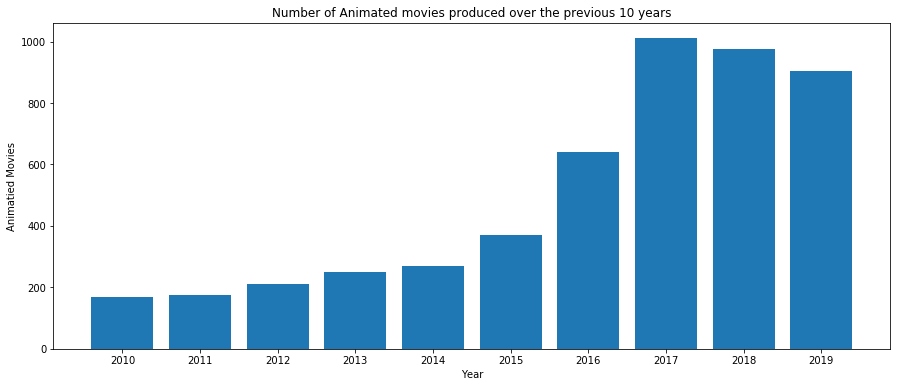

In [23]:
# Show animated movies released from 2010 through 2019
new_df = original_tmdb_by_revenue_df.loc[(original_tmdb_by_revenue_df['release_year'] > 2009) & (original_tmdb_by_revenue_df['release_year'] < 2020)]
y= new_df.groupby("release_year")['title'].count()
x= new_df.groupby("release_year")['title'].count().index

# Ploting The Graph

figure, ax=plt.subplots(figsize=(15,6))
ax.bar(x,y)
ax.set_title('Number of Animated movies produced over the previous 10 years')
ax.set_xlabel('Year')
ax.set_ylabel('Animatied Movies');
plt.xticks(x);
plt.savefig('graphs/Number_animated_movies.png')

## Top Grossing Animated Movies

#### Find top grossing movies

In [24]:
sorted_by_revenue=original_tmdb_by_revenue_df.sort_values(by="revenue", ascending=False).head(10).reset_index(drop=True)


In [25]:
Y=sorted_by_revenue.revenue
X=sorted_by_revenue.title

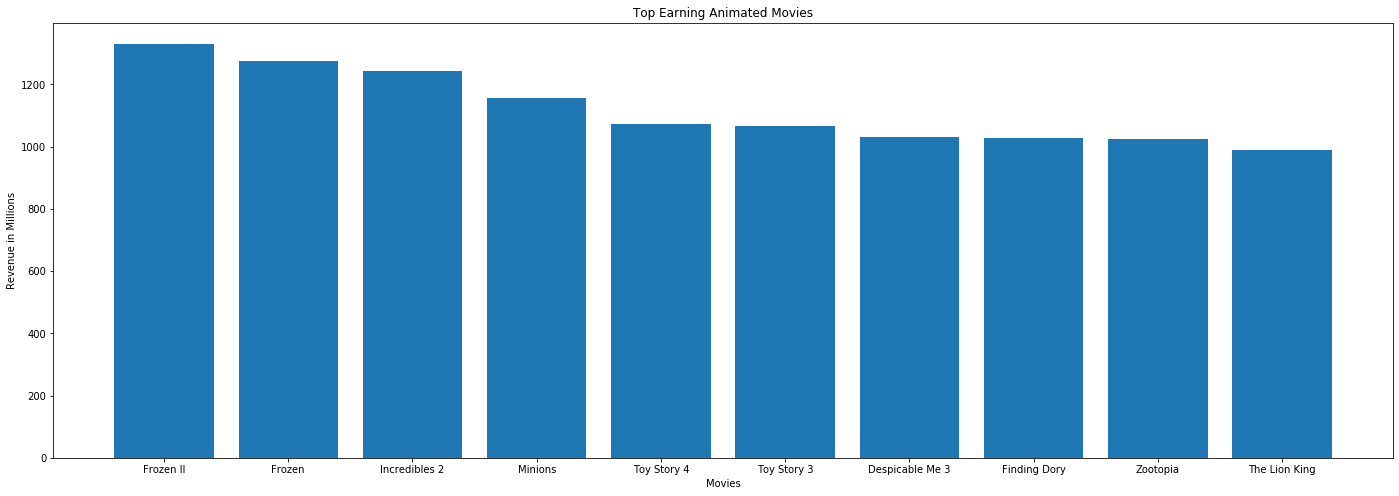

In [26]:
figure, ax=plt.subplots(figsize=(24,8))
ax.bar(X,Y/1e6)
ax.set_title('Top Earning Animated Movies')
ax.set_xlabel('Movies')
ax.set_ylabel('Revenue in Millions');
plt.savefig('graphs/top_earning_animated_movies.png')

### Studios With Most Movie Releases

In [27]:
Studio= pd.read_csv('Data/studio_file.csv')

In [28]:
X1= Studio.groupby("studio")["title"].count().nlargest(10).index
Y1= Studio.groupby("studio")["title"].count().nlargest(10)

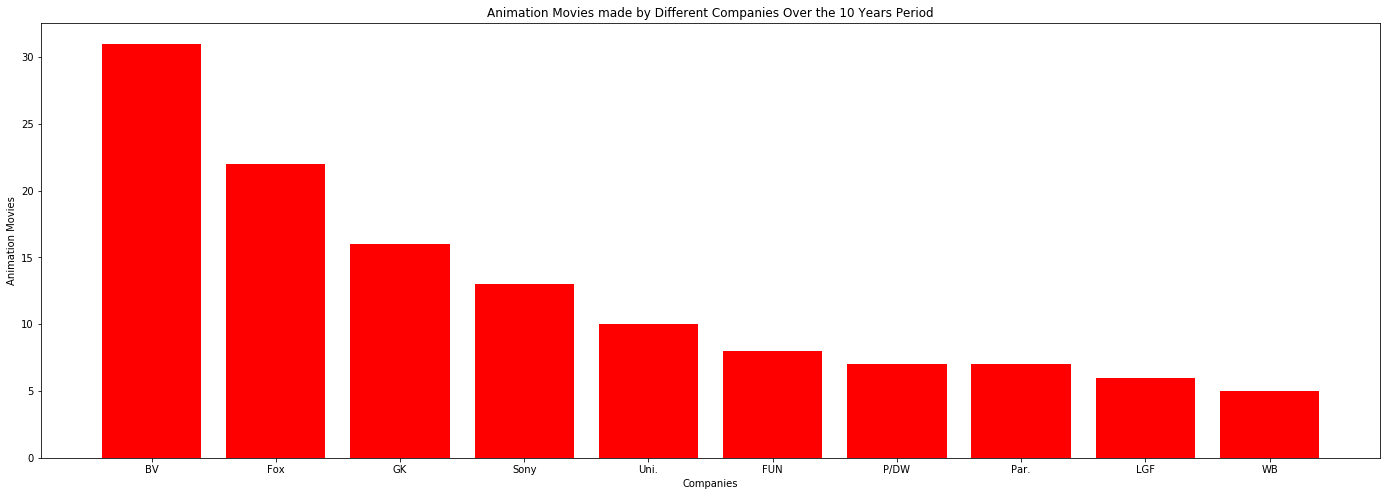

In [29]:
figure, ax=plt.subplots(figsize=(24,8))

ax.bar(X1,Y1,color= 'r')
ax.set_title('Animation Movies made by Different Companies Over the 10 Years Period')
ax.set_xlabel('Companies')
ax.set_ylabel('Animation Movies')
plt.savefig('graphs/top_10_animated_movie_companies.png')

### Trends in Animated Film Run Times

In [30]:
df = pd.read_csv('Data/IMDB_With_Movie_Titles.csv')

In [31]:
df_RunTime=df[['genres', 'start_year', 'runtime_minutes']]

In [32]:
Y= df_RunTime.groupby("start_year")["runtime_minutes"].mean()
X= df_RunTime.groupby("start_year")["runtime_minutes"].mean().index

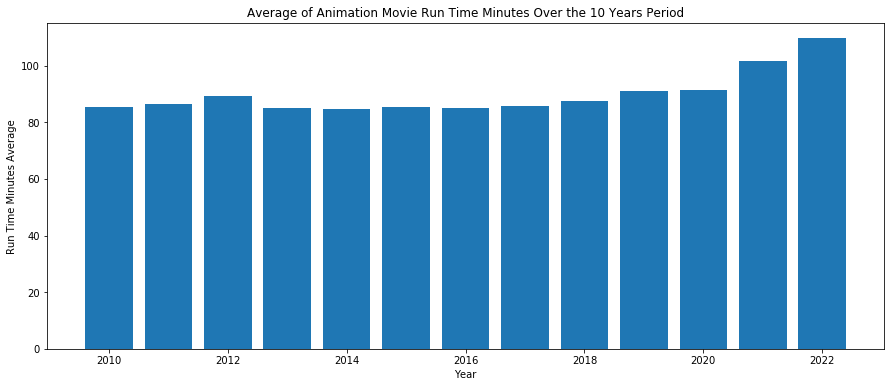

In [33]:
figure, ax=plt.subplots(figsize=(15,6))
ax.bar(X,Y)
ax.set_title('Average of Animation Movie Run Time Minutes Over the 10 Years Period')
ax.set_xlabel('Year')
ax.set_ylabel('Run Time Minutes Average')
plt.savefig('graphs/average_animated_runtime.png')

## Correlations of Costs and Earnings for Animated and Non-Animated Movies

In [34]:
non_animated_merge_df.production_budget.corr(non_animated_merge_df.worldwide_gross)

0.7984802918295224

In [35]:
non_animated_merge_df.worldwide_gross.mean()/non_animated_merge_df.production_budget.mean()

3.04830174252247

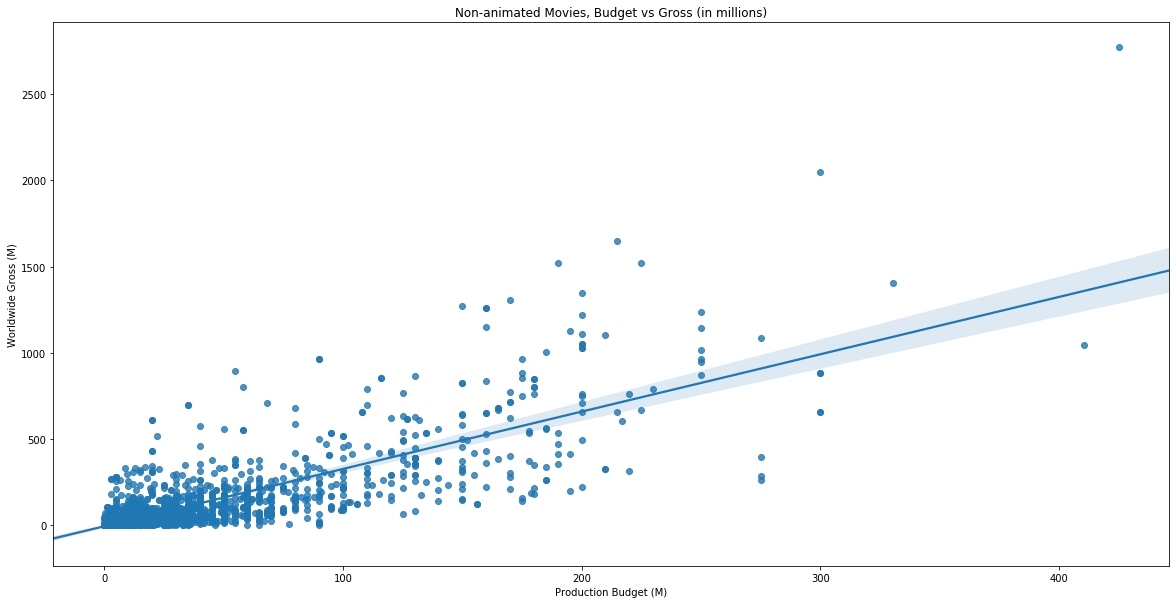

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
sns.regplot(non_animated_merge_df.production_budget/1e6, non_animated_merge_df.worldwide_gross/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Non-animated Movies, Budget vs Gross (in millions)")
plt.savefig('graphs/Non-animated_Movies_Budget_vs_Gross.png')

#### correlation of data and cost to earnings ratio for animated movies

In [37]:
tmdb_by_revenue_df.budget.corr(tmdb_by_revenue_df.revenue)

0.7051248042113353

In [38]:
tmdb_by_revenue_df.revenue.mean()/tmdb_by_revenue_df.budget.mean()

3.545580252739539

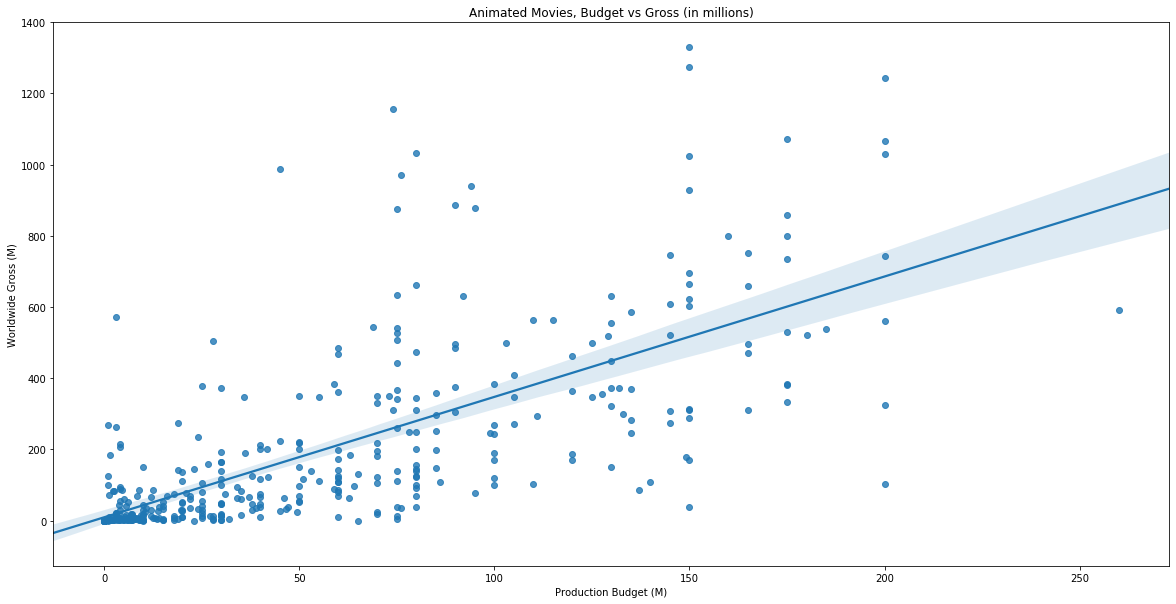

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
sns.regplot(tmdb_by_revenue_df['budget']/1e6, tmdb_by_revenue_df['revenue']/1e6)
ax.set_xlabel("Production Budget (M)")
ax.set_ylabel("Worldwide Gross (M)")
ax.set_title("Animated Movies, Budget vs Gross (in millions)")
plt.savefig("graphs/Animated_Movies_Budget_vs_Gross.png")

# Appendix:

## Data Collection

### To Get TMDB API Results:

#### We call the api asking for all titles with the genre id for Animation (16), sorted by revenue from greatest to least
#### The first call will return only the first 20 results, along with the number of results and number of total pages, allowing us to iterate through calling all pages


In [40]:
# first_call = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16&sort_by=revenue.desc')
# num_pages = first_call.json()['total_pages']

In [41]:
# def call_TMDB_api(page):
#     return requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' +  api_key + '&with_genres=16&sort_by=revenue.desc&page='+ page).json()['results']

In [42]:
# results = []
# for i in range(num_pages):
#     results += call_TMDB_api(str(i+1))

#### Once we have all 10,000 title results, we do another api call to get details for each title

In [43]:
# def turn_response_into_list(response):
#     details = []
#     for movie in response:
#         details.append(requests.get('https://api.themoviedb.org/3/movie/'+ str(movie['id']) +'?api_key='+ api_key).json())
#     return details

In [44]:
# THIS TAKES 23 MINUTES TO RUN!!!!

# results_by_rev = turn_response_into_list(results)

#### Test to make sure results from API are consistent:

In [45]:
# THIS TAKES 23 MINUTES TO RUN!!!!

# compare_results_by_rev = turn_response_into_list(results)

In [46]:
# compare_results_by_rev == results_by_rev
# *returned True*

In [47]:
# keys = all_movies[1].keys()

In [48]:
# tmdb_data_by_revenue = pd.DataFrame(results_by_rev, columns = keys)

In [49]:
# tmdb_data_by_revenue.to_csv('tmdb_animation_by_revenue.csv')

# WEBSCRAPING TEST (for future investigations)

#### Create a sample of our current observations to test supplementing with webscraping

In [50]:
# test_ids = tmdb_df.loc[4100:4200].imdb_id
# test_ids = test_ids.dropna()

#### scraping function

In [51]:
# def scrape_budget(imdb_id):
#     url = 'https://www.imdb.com/title/'
#     html_page = requests.get(url+imdb_id)
#     soup = BeautifulSoup(html_page.content, 'html.parser')
#     details = soup.find('div', id="titleDetails")
#     budget = details.find(text=re.compile('Budget:'))
#     try:
#       return budget.parent.parent.contents[2]
#     except:
#       return "0"

#### get results

In [52]:
# results = []
# for id in test_ids:
#     results.append(scrape_budget(id))

#### compare results to originals

In [53]:
# for budget in tmdb_df.loc[4100:4200].budget:
#     print(budget)

In [54]:
# for budget in tmdb_df.loc[4100:4200].budgets:
#     print(budget)